In [1]:
import sys
sys.path.append("/home/salmon/workspace/fy_trans/python")
sys.path.append("/home/salmon/workspace/SpDev/SpCommon")
sys.path.append("/home/salmon/workspace/SpDev/SpDB")

from spdm.common.logger import logger
from spdm.data import Collection
import matplotlib.pyplot as plt
import numpy as np
from enum import IntFlag

import fenics
import mshr
from fenics import dot,grad,pi


In [2]:
db = Collection("EAST:///home/salmon/public_data/~t/",default_tree_name="efit_east")
entry = db.open(shot=55555).entry


2020-10-20 14:06:57,471 DEBUG [spdm] /home/salmon/workspace/SpDev/SpCommon/spdm/util/sp_export.py:73:sp_find_module: spdm.data.plugins.PluginEAST#EASTCollection
2020-10-20 14:06:57,473 INFO [spdm] /home/salmon/workspace/SpDev/SpDB/spdm/data/Plugin.py:70:find_plugin: Load Plugin: EASTCollection
2020-10-20 14:06:57,509 DEBUG [spdm] /home/salmon/workspace/SpDev/SpCommon/spdm/util/sp_export.py:73:sp_find_module: spdm.data.plugins.PluginMDSplus#MDSplusCollection
2020-10-20 14:06:57,510 INFO [spdm] /home/salmon/workspace/SpDev/SpDB/spdm/data/Plugin.py:70:find_plugin: Load Plugin: MDSplusCollection
2020-10-20 14:06:57,511 DEBUG [spdm] /home/salmon/workspace/SpDev/SpDB/spdm/data/Collection.py:49:__init__: Open MDSplusCollection : mdsplus:///home/salmon/public_data/~t/
2020-10-20 14:06:57,513 DEBUG [spdm] /home/salmon/workspace/SpDev/SpDB/spdm/data/Collection.py:49:__init__: Open EASTCollection : URISplitResult(schema='EAST', authority='', path='/home/salmon/public_data/~t/', query=None, fragme

In [3]:

vessel_inner_points= np.array([entry.wall.description_2d.vessel.annular.outline_inner.r.__value__(),    
                                          entry.wall.description_2d.vessel.annular.outline_inner.z.__value__()]).transpose([1,0]) 
vessel_inner = mshr.Polygon([fenics.Point((p[0],p[1])) for p in vessel_inner_points])

vessel_outer_points= np.array([entry.wall.description_2d.vessel.annular.outline_outer.r.__value__(),    
                                          entry.wall.description_2d.vessel.annular.outline_outer.z.__value__()]).transpose([1,0])  
vessel_outer = mshr.Polygon([fenics.Point((p[0],p[1])) for p in vessel_outer_points])

limiter_points =  np.array([entry.wall.description_2d[0].limiter.unit[0].outline.r.__value__(),
                                 entry.wall.description_2d[0].limiter.unit[0].outline.z.__value__()]).transpose([1,0]) 

limiter = mshr.Polygon([fenics.Point(p[0],p[1]) for p in limiter_points])

pf_coils=[]
J_coils=[]
rpos=[]
zpos=[]

itime=30000

for coil in entry.pf_active.coil:
    rect=coil.element[0].geometry.rectangle.__value__()
    rpos.append(rect.r-rect.width/2.0)
    rpos.append(rect.r+rect.width/2.0)
    zpos.append(rect.z-rect.height/2.0)
    zpos.append(rect.z+rect.height/2.0)
    pf_coils.append(mshr.Rectangle(fenics.Point(rect.r-rect.width/2.0,rect.z-rect.height/2.0),fenics.Point(rect.r+rect.width/2.0,rect.z+rect.height/2.0) ))
    J=coil.current.data.__value__()
    coeff=coil.element[0].turns_with_sign/(rect.width*rect.height)
    if len(J)>0:
        J_coils.append(J[itime]*coeff)
    else:
        J_coils.append(0.0)


rmin=min(rpos)
rmax=max(rpos)
zmin=min(zpos)
zmax=max(zpos)

box=mshr.Rectangle( fenics.Point(rmin-0.1*(rmax-rmin),zmin-0.1*(zmax-zmin)),fenics.Point(rmax+0.1*(rmax-rmin),zmax+0.1*(zmax-zmin)))



2020-10-20 14:07:00,741 DEBUG [spdm] /home/salmon/workspace/SpDev/SpDB/spdm/data/plugins/PluginMDSplus.py:45:open_mdstree: Opend MDSTree: pcs_east 55555 mode="NORMAL"


In [4]:

class MeshTag(IntFlag):
    VACUUM =0
    LIMITER =1
    CONTAINER = 2
    WALL=3
    COIL =10


domain= box
# domain.set_subdomain(MeshTag.LIMITER,limiter )
# domain.set_subdomain(MeshTag.CONTAINER,vessel_inner-limiter ) #
# domain.set_subdomain(MeshTag.WALL,vessel_outer-vessel_inner )

for idx in range(14):
    domain.set_subdomain(MeshTag.COIL+idx, pf_coils[idx] )

mesh =  mshr.generate_mesh(box, 32)

# markers =fenics.MeshFunction('size_t', mesh, 2, mesh.domains())
# dx =fenics.Measure('dx', domain=mesh, subdomain_data=markers)




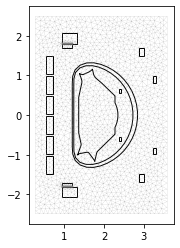

In [5]:
fg=plt.figure()
mesh_cell,fig_aix=mesh_plot=fenics.plot(mesh  )

mesh_cell.set_linewidth(0.1)

plt.gca().add_patch(plt.Polygon(limiter_points , fill=False,closed=True))
plt.gca().add_patch(plt.Polygon(vessel_outer_points , fill=False,closed=True))
plt.gca().add_patch(plt.Polygon(vessel_inner_points , fill=False,closed=True))

for coil  in entry.pf_active.coil:
    rect=coil.element[0].geometry.rectangle.__value__() 
    plt.gca().add_patch(plt.Rectangle((rect.r-rect.width/2.0, rect.z-rect.height/2.0), rect.width, rect.height, fill=False))

plt.axis('scaled')
plt.show()

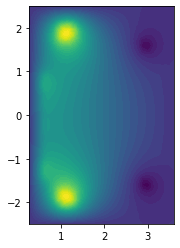

In [6]:
# Define function space
V =fenics.FunctionSpace(mesh, 'P', 1)

# Define boundary condition
bc = fenics.DirichletBC(V, fenics.Constant(0), 'on_boundary')

# Define subdomain markers and integration measure
markers =fenics.MeshFunction('size_t', mesh, 2, mesh.domains())
dx = fenics.Measure('dx', domain=mesh, subdomain_data=markers)

 

# Define magnetic permeability


class Permeability(fenics.UserExpression):
    def __init__(self, markers, **kwargs):
        super().__init__(**kwargs)
        self.markers = markers

    def eval_cell(self, values, x, cell):
        if self.markers[cell.index] == MeshTag.VACUUM:
            values[0] = 4*pi*1e-7  # vacuum
        elif self.markers[cell.index] == MeshTag.WALL:
            values[0] = 6.3e-3     # iron (should really be 6.3e-3)
        elif self.markers[cell.index] == MeshTag.LIMITER:
            values[0] = 4*pi*1e-7  # vacuum    
        elif self.markers[cell.index] == MeshTag.CONTAINER:
            values[0] = 4*pi*1e-7  # vacuum
        elif self.markers[cell.index] >= MeshTag.COIL:
            values[0] = 1.26e-6   # copper


mu = Permeability(markers, degree=1)

# Define variational problem
A_z =fenics.TrialFunction(V)
v = fenics.TestFunction(V)
a = (1 / mu)*dot(grad(A_z), grad(v))*dx
L = sum(fenics.Constant(J)*v*dx(MeshTag.COIL+idx) for idx,J in enumerate(J_coils))


# Solve variational problem
A_z = fenics.Function(V)
fenics.solve(a == L, A_z, bc)

# Compute magnetic field (B = curl A)
W = fenics.VectorFunctionSpace(mesh, 'P', 1)
B = fenics.project(fenics.as_vector((A_z.dx(1), -A_z.dx(0))), W)

# Plot solution
fenics.plot(A_z)

In [10]:
help(A_z.dx(0))

Help on Indexed in module ufl.indexed object:

class Indexed(ufl.core.operator.Operator)
 |  Indexed(expression, multiindex)
 |  
 |  Base class for all operators, i.e. non-terminal expression types.
 |  
 |  Method resolution order:
 |      Indexed
 |      ufl.core.operator.Operator
 |      ufl.core.expr.Expr
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __getitem__(self, key)
 |  
 |  __hash__ = compute_expr_hash(expr)
 |      Compute hashes of *expr* and all its nodes efficiently, without using Python recursion.
 |  
 |  __init__(self, expression, multiindex)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __str__(self)
 |      Return pretty print string representation of this object.
 |  
 |  evaluate(self, x, mapping, component, index_values, derivatives=())
 |      Evaluate expression at given coordinate with given values for terminals.
 |  
 |  ----------------------------------------------------------------------
 |  Static meth

In [15]:
class DefaultDict(dict):
     def __missing__(self, k):
         self.__setitem__(k,k)
         print(k)
         return k
                 
d=DefaultDict()
d[1]=6
d["hello"]

hello


'hello'

In [14]:
print(d)

{1: 6, 'hello': 'hello'}


In [8]:
gate.efit(eq)

204

In [1]:
import numpy as np

In [3]:
a=np.zeros([10,10])